In [33]:
import tensorflow as tf
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal
from scipy.ndimage import uniform_filter
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [35]:
def load_model(model_path):
    if not tf.io.gfile.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found.")
    
    model = tf.keras.models.load_model(model_path)
    return model

In [37]:
def resample_signal(original_signal, original_fs, target_fs=100):
    if original_fs == target_fs:
        return original_signal
    gcd = np.gcd(int(original_fs), int(target_fs))
    up = target_fs // gcd
    down = original_fs // gcd
    return signal.resample_poly(original_signal, up, down, axis=0)

In [39]:
def adjust_signal_length(signal, target_length):
    current_length = signal.shape[0]
    if current_length < target_length:
        print(f"Padding signal from {current_length} to {target_length} samples")
        return np.pad(signal, ((0, target_length - current_length), (0, 0)), mode='constant')
    return signal[:target_length, :]

In [41]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv1D):
            return layer.name
    raise ValueError("No convolutional layer found in the model.")

In [43]:
def compute_grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
    
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    
    conv_output = conv_outputs[0].numpy()
    conv_output *= pooled_grads.numpy()
    
    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    
    return heatmap, class_idx.numpy()

In [45]:
def plot_ecg_with_gradcam(signal, heatmap, lead_names, fs, sample_idx, class_idx):
    num_leads = signal.shape[1]
    time = np.arange(signal.shape[0]) / fs
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(num_leads, 1, figure=fig)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.ptp(heatmap) + 1e-8)
    for lead in range(num_leads):
        ax = fig.add_subplot(gs[lead, 0])
        vertical_offset = lead * 3
        ax.plot(time, signal[:, lead] + vertical_offset, linewidth=1, color='black')
        heatmap_extent = [time[0], time[-1], vertical_offset - 1.5, vertical_offset + 1.5]
        ax.imshow(
            np.expand_dims(heatmap_normalized, axis=0),
            cmap='viridis',
            aspect='auto',
            extent=heatmap_extent,
            alpha=0.4,
            origin='lower'
        )
        ax.set_ylabel(lead_names[lead], rotation=0, ha='right', va='center')
        ax.set_yticks([])
        ax.set_ylim(vertical_offset - 2, vertical_offset + 2)
        if lead != num_leads - 1:
            ax.set_xticks([])
    plt.suptitle(f"ECG Sample #{sample_idx} - Predicted Class: {class_idx}\nGrad-CAM Heatmap Overlay", y=0.92)
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

In [47]:
#Helper
def get_header_file(record):
    if not record.endswith('.hea'):
        header_file = record + '.hea'
    else:
        header_file = record
    return header_file

def load_text(filename):
    with open(filename, 'r') as f:
        string = f.read()
    return string

def load_header(record):
    header_file = get_header_file(record)
    header = load_text(header_file)
    return header

def load_signals(record):
    signal, fields = wfdb.rdsamp(record)
    return signal, fields

def get_variable(string, variable_name):
    variable = ''
    has_variable = False
    for l in string.split('\n'):
        if l.startswith(variable_name):
            variable = l[len(variable_name):].strip()
            has_variable = True
    return variable, has_variable

def remove_extra_characters(x):
    x = str(x)
    x = x.replace('"', '').replace("'", "")
    x = x.replace('(', '').replace(')', '').replace('[', '').replace(']', '').replace('{', '').replace('}', '')
    x = x.replace(' ', '').replace('\t', '')
    x = x.strip()
    return x

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def sanitize_boolean_value(x):
    x = remove_extra_characters(x)
    if (is_number(x) and float(x)==0) or (remove_extra_characters(x).casefold() in ('false', 'f', 'no', 'n')):
        return 0
    elif (is_number(x) and float(x)==1) or (remove_extra_characters(x).casefold() in ('true', 't', 'yes', 'y')):
        return 1
    else:
        return float('nan')

def get_label(string, allow_missing=False):
    label, has_label = get_variable(string, label_string)
    if not has_label and not allow_missing:
        raise Exception('No label is available: are you trying to load the labels from the held-out data?')
    label = sanitize_boolean_value(label)
    return label

def load_label(record):
    header = load_header(record)
    label = get_label(header)
    return label

In [49]:
# Configuration
MODEL_PATH = "./model/model.keras"
RECORD_PATH = "./input/11892"
REQUIRED_LENGTH = 1000
NUM_SAMPLES_TO_PLOT = 1
TARGET_FS = 100

In [51]:
ecg , text= load_signals(RECORD_PATH)

try:
    # Load model and data
    model = load_model(MODEL_PATH)
    ecg , text= load_signals(RECORD_PATH)
    
    conv_layer_name = find_last_conv_layer(model)
    
    # Validate ECG signal dimensions
    original_signal = ecg
    original_fs = int(text["fs"])
    if original_signal.ndim != 2 or original_signal.shape[1] != 12:
        raise ValueError("ECG signal must have shape (samples, 12 leads).")

except Exception as e:
    print(f"Error loading model or data: {str(e)}")

Resampled samples: 734, Target FS: 100
Total samples: 734, Segments to process: 1
Processing segment 1/1
Padding signal from 734 to 1000 samples
Original Signal - Predicted Class: 0


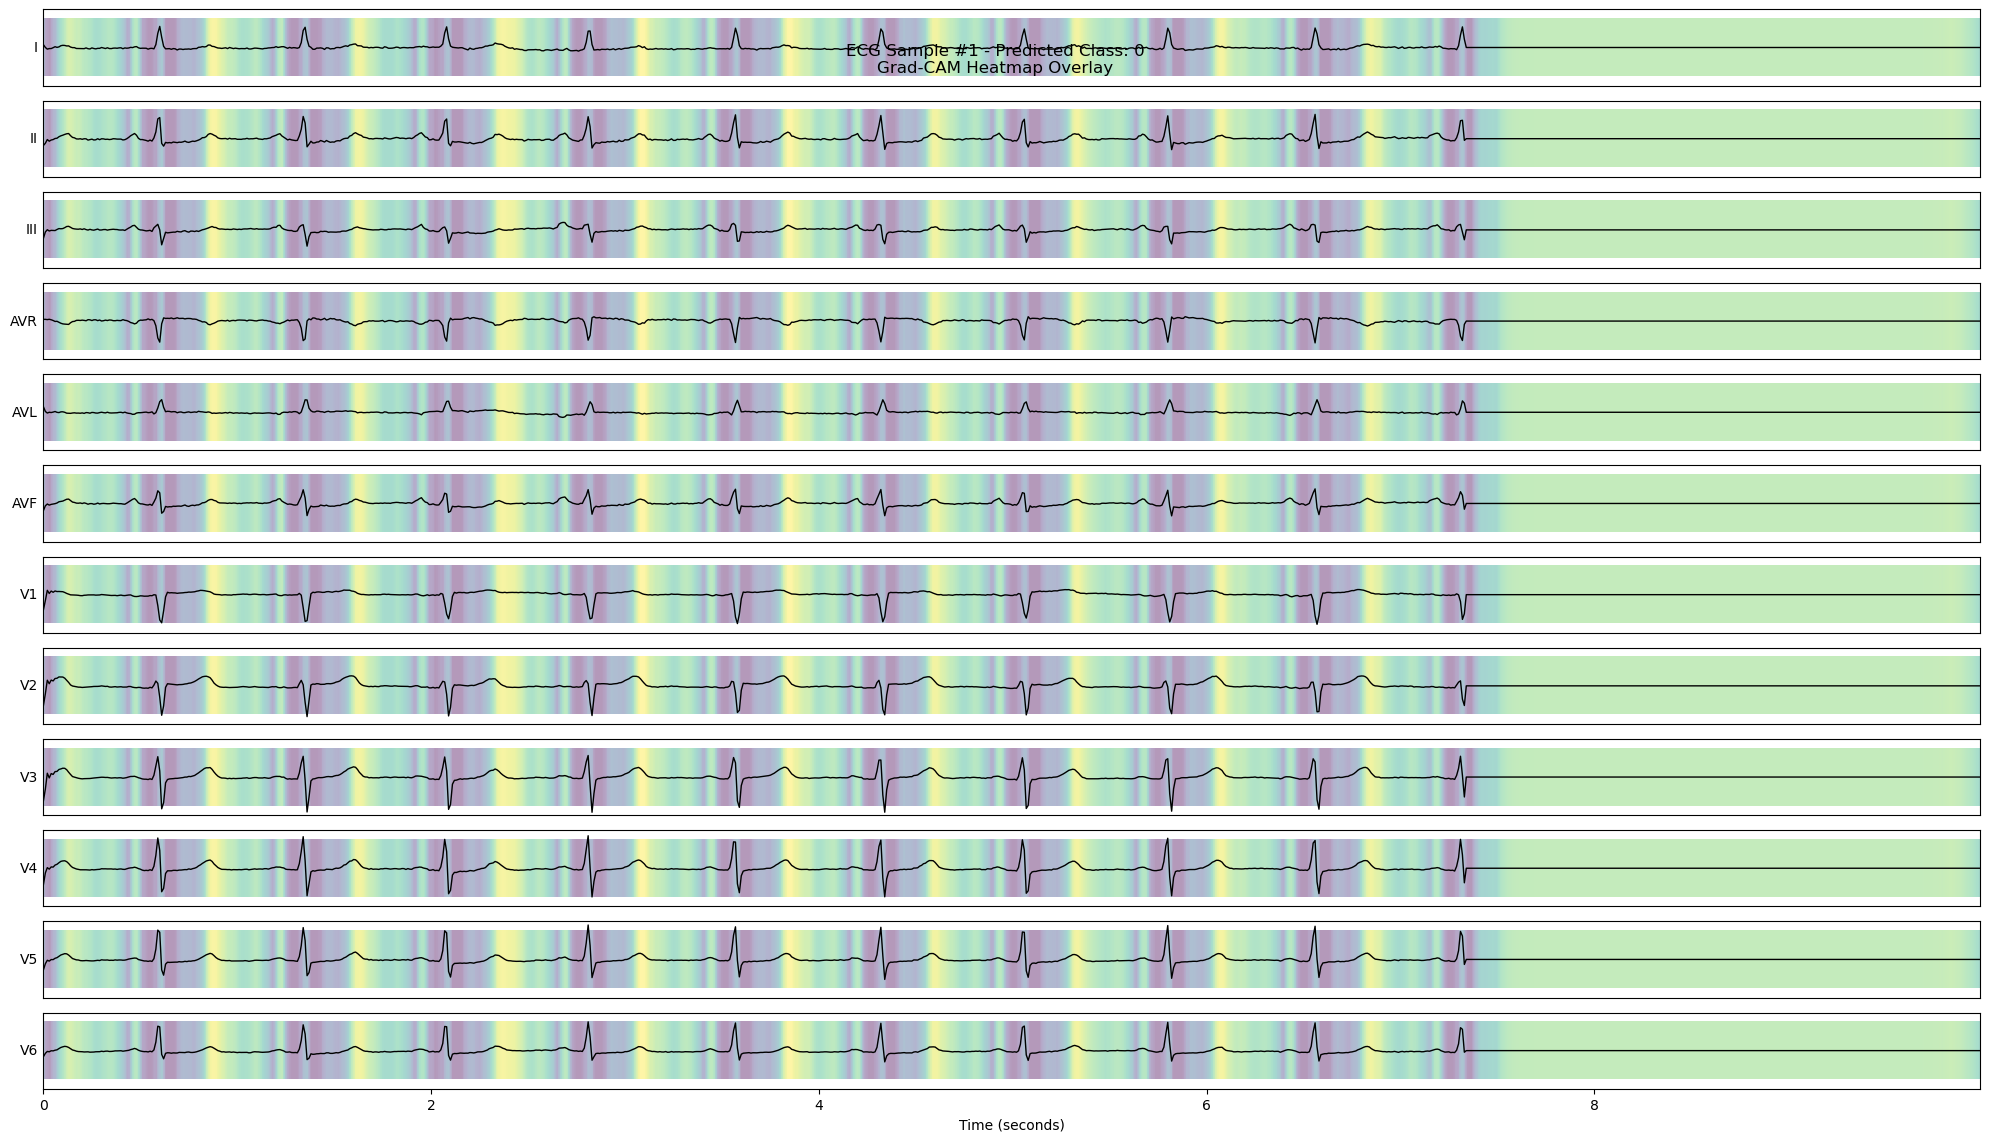

In [53]:
try:    
    # Resample and process signal
    resampled_signal = resample_signal(original_signal, original_fs, TARGET_FS)
    total_samples = resampled_signal.shape[0]
    
    print(f"Resampled samples: {total_samples}, Target FS: {TARGET_FS}")
    num_segments = max(1, total_samples // REQUIRED_LENGTH)
    print(f"Total samples: {total_samples}, Segments to process: {num_segments}")
    
    for i in range(num_segments):
        print(f"Processing segment {i+1}/{num_segments}")
        start_idx = i * REQUIRED_LENGTH
        end_idx = start_idx + REQUIRED_LENGTH
        
        segment = resampled_signal[start_idx:end_idx, :]
        adjusted_signal = adjust_signal_length(segment, REQUIRED_LENGTH)
        
        input_tensor = tf.convert_to_tensor(
            np.expand_dims(adjusted_signal, 0), dtype=tf.float32
        )
        
        # Compute Grad-CAM
        heatmap_original, class_idx_original = compute_grad_cam(model, input_tensor, conv_layer_name)
        
        # Plot Grad-CAM
        print(f"Original Signal - Predicted Class: {class_idx_original}")
        plot_ecg_with_gradcam(
            adjusted_signal,
            heatmap_original,
            text['sig_name'],
            TARGET_FS,
            sample_idx=i+1,
            class_idx=class_idx_original
        )
        
except Exception as main_error:
    print(f"Critical error: {str(main_error)}")